# Lab 4: optimization
## Task 1: 1D optimization
In this task you will write a function that passes <code>fixed_lift</code> from Lab 3 to an optimizer to find $z_u^{(2)}$ that will give a desired lift for a given angle of attack. First import the necessary modules (note that you will be using the <code>minimize</code> method from SciPy).

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from aclab3 import *
from scipy.optimize import minimize

First we'll start with a simple function $x^2$:

In [13]:
def square(x):
    y = x**2
    return y

We know the optimum should be zero at $x=0$. If we pass <code>square</code> to the <code>minimize</code> optimizer, and give it a starting point of 0.5 (here we'll pretend this is our best guess at the location of the minimum), we should get an answer close to, but not exactly $x=0$:

In [14]:
opt_out = minimize(square, 0.5)
print(opt_out)

      fun: 1.3877787394224154e-17
 hess_inv: array([[1]])
      jac: array([  2.23517417e-08])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([  3.72529024e-09])


Now write a function <code>one_dim_opt(x0, alpha, target_cl)</code>that finds the value of $z_u^{(2)}$ that minimizes the output of <code>fixed_lift</code> for a given $\alpha$ and target $C_L$. Unlike the $x^2$ example above, you'll need to pass two extra arguments to <code>fixed_lift</code>, which you are not optimizing. Use the syntax <code>minimize(..., ..., args = (alpha, target_cl))</code> to pass these additional arguments. You can find out more about scipy.optimize [here](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/optimize.html#).

In [18]:
def one_dim_opt(x0, alpha, target_cl):
    """x0 is the initial guess. The first two parts of the minimize function (... in the text above)are the function
    and x0 respectivly. The function will be fixed_lift (as stated above). x0 is the same as the function input."""
    opt = minimize(fixed_lift, x0, args=(alpha, target_cl))
    return opt

Try out your code (it will take some time to run, as <code>vortex_panel</code> will be called many times - <code>opt_out.nfev</code> tells you how many):

      fun: 2.68809746285275e-10
 hess_inv: array([[ 6.39456638]])
      jac: array([ -8.89271916e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([ 0.50225482])


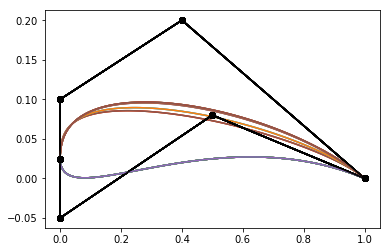

In [19]:
w0 = 0.3
alpha = 0.0
cl = 0.8
opt_out = one_dim_opt(w0, alpha, cl)
print(opt_out)

Run the result through <code>vortex_panel</code> to see the aerofoil and $C_P$ profile:

0.799983604582


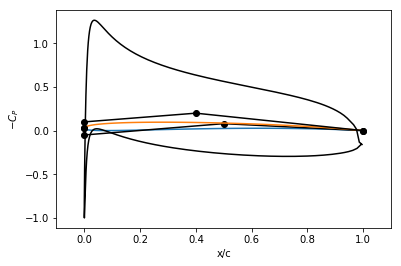

In [20]:
points = parametric_aerofoil(opt_out.x)
[cl, cp, xc] = vortex_panel(points, 0.0, 1)
print(cl)

In [21]:
"""Check that one_dim_opt returns the correct output"""
assert np.allclose(opt_out.x, 0.50225482, 0.01)

## Task 2: four variable parametric aerofoil
In the next task you will optimize four control point weightings: $z_l^{(1)}$, $z_l^{(2)}$, $z_u^{(1)}$ and $z_u^{(2)}$. So first, you need to create a parametric aerofoil function, similar to in Lab 3, but now <code>parametric_aerofoil_four_var(w)</code> takes an array of four weights as its input.

Below write the function parametric_aerofoil_four_var(w):

In [22]:
def parametric_aerofoil_four_var(w):
    """Takes w as an input where w is an array of weights for l1, l2, u1, and u2
    and returns the points of a weighted bezier curve"""
    # control points for each curve
    p = np.array([[1, 0.0], [0.5, 0.08], [0.0, -0.05]])
    q = np.array([[0.0, 0.1], [0.4, 0.2], [1, 0.0]])
    # setting up weights: zp represents points l0-l3 and zq represents u0-u3
    zp = np.array([1, w[0], w[1], 1])
    zq = np.array([1, w[2], w[3], 1])
    # n and m are the order of p and q respectively
    n = np.float(p.shape[0])
    m = np.float(q.shape[0])
    # calculate connection point
    q_start = p_end = (n / (n + m)) * p[-1,:] + (m / (n + m)) * q[0,:]
    # add to control points
    pp = np.vstack([p, p_end])
    qq = np.vstack([q_start, q])
    # calculate two curves 
    lower = rational_bezier(pp, zp)
    upper = rational_bezier(qq, zq)
    # and join together and remove repeat point
    points = np.concatenate([lower,upper[1:]])

    return points

Check it works:

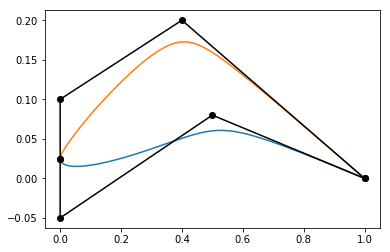

In [23]:
w = np.array([5.0, 1.0, 0.6, 5.0])
points = parametric_aerofoil_four_var(w)

The weightings above yield a rather strange aerofoil but, as before, the function should still return 201 points, starting at the trailing edge $l^{(0)}$, passing through the leading edge $l^{(3)}=u^{(0)}$, and ending at the trailing edge $u^{(3)}$:

In [24]:
print(len(points))
print(points[0,:])
print(points[100,:])
print(points[-1,:])

201
[ 1.  0.]
[ 0.     0.025]
[ 1.  0.]


Running <code>vortex_panel</code> for this aerofoil, we see that the strange curvature leads to an equally strange pressure profile. Note that with such high curvature, the flow would separate unless the velocity were very slow or the medium very viscous (that is the flow had a low Reynolds number), so this pressure profile would not normally be observed.

1.08752675871


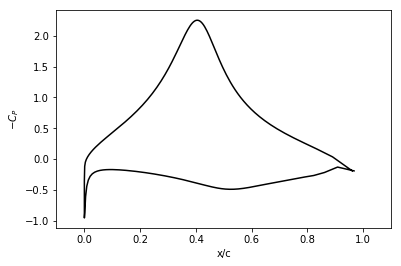

In [25]:
[cl, cp, xc] = vortex_panel(points, 0, 1)
print(cl)

## Task 2: 4D optimization
In this task, as in Lab 3, you will create a function to minimize, which has its minimum when the output of <code>vortex_panel</code> equals a target lift.

Complete the code for this function below:

In [63]:
def fixed_lift_four_var(w, alpha, target_cl):
    pts = parametric_aerofoil_four_var(w)
    [cl, cp, xc] = vortex_panel(pts, alpha, 0)
    f = (cl - target_cl)**2
    return f

And test it:

0.588361856744


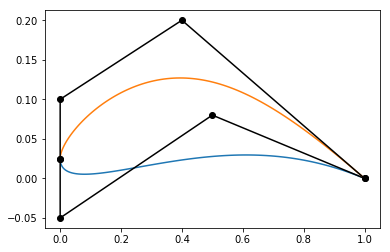

In [64]:
w = np.array([1.0, 0.8, 0.6, 1.2])
alpha = 2
target_cl = 0.4
guess = fixed_lift_four_var(w,alpha, target_cl)
print(guess)

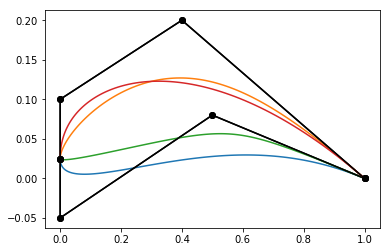

In [65]:
"""Check that fixed_lift_four_var returns the correct output"""
assert np.allclose(fixed_lift_four_var(np.array([1.0, 0.8, 0.6, 1.2]),2, 0.4),0.588361856744, 0.0001)
assert np.allclose(fixed_lift_four_var(np.array([2.0, 0.2, 1.6, 1.3]),0, 0.2),0.652649425392, 0.0001)

Now write a function <code>four_dim_opt(w0, weight_limits, alpha, target)</code> that finds the values of $z_l^{(1)}$, $z_l^{(2)}$, $z_u^{(1)}$ and $z_u^{(2)}$ that minimizes the output of <code>fixed_lift_four_var</code> for a given $\alpha$ and target $C_L$. You'll need to use an aditional argument when calling the optimizer: <code>minimize(..., ..., bounds = weight_limits, args = (alpha, target_cl))</code>. <code>weight_limits</code> is an array of upper and lower bounds on the control point weights. Example inputs to your function are given below (run this cell):

In [66]:
alpha=0.0
target=0.6
x0=[0.6, 0.6, 0.6, 0.6]
weight_limits=((0.2, 2.0),(0.2, 0.8),(0.2, 0.8),(0.2, 2.0))

Below write the function <code>four_dim_opt(w0, weight_limits, alpha, target)</code>:

In [82]:
def four_dim_opt(w0, weight_limits, alpha, target):
    opt = minimize(fixed_lift_four_var, w0, bounds=weight_limits, args=(alpha, target))
    return opt

Now test your code:

      fun: 2.8815148683277206e-14
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.27074131e-07,   3.28912993e-08,   6.06293800e-09,
        -1.73688701e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 35
      nit: 5
   status: 0
  success: True
        x: array([ 0.25639531,  0.78194503,  0.66297143,  0.24867165])


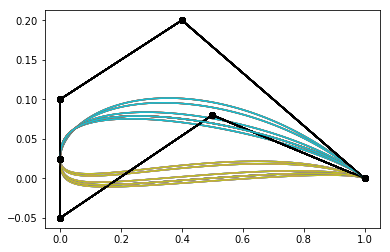

In [83]:
opt_out = four_dim_opt(x0, weight_limits, alpha, target)
print(opt_out)

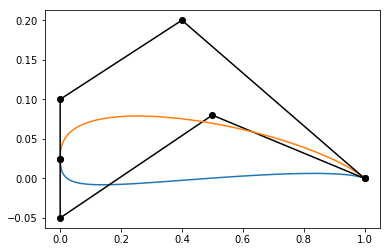

In [84]:
points = parametric_aerofoil_four_var(opt_out.x)

0.59999983025


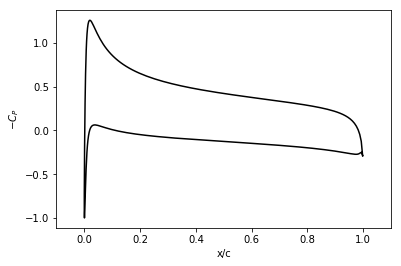

In [85]:
[cl, cp, xc]=vortex_panel(points, 0.0, 1)
print(cl)

In [86]:
"""Check that four_dim_opt returns the correct output"""
assert np.allclose(opt_out.x,[ 0.25639524,  0.78194507,  0.66297512,  0.24867184], 0.01)